# Classificação de Jogos Candidatos ao GOTY

Este notebook desenvolve um modelo para identificar jogos que poderiam ser candidatos ao **Game of the Year (GOTY)** usando o *Steam Games Dataset*.

Como trabalhei outros MVPs nesta linha dos jogos, decidi usar os conhecimentos adquiridos anteriormente para aplicar neste treinamento. A proposta envolve uma classificação supervisionada que visa sugerir jogos potencialmente candidatos ao prêmio GOTY, com base nas informações disponíveis no dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Escolha do Dataset e Importação

Foi escolhido um dataset do Kaggle, utilizado previamente em um MVP, que contém informações relevantes para o problema. O dataset foi armazenado em uma pasta no Google Drive para ser acessado diretamente pelo Colab.

A escolha deste dataset se deu pela disponibilidade de informações críticas, como notas dos críticos e vendas totais, que são cruciais para a classificação dos jogos.


In [2]:
import pandas as pd

# URL do dataset no GitHub
url = "https://raw.githubusercontent.com/Maestrelli9/MVP_Machine_Learning_PUC/refs/heads/main/vgchartz-2024.csv"

# Carregar o dataset usando Pandas
data = pd.read_csv(url)

# Exibir as primeiras linhas do dataset
print(data.head())






                                             img                        title  \
0  /games/boxart/full_6510540AmericaFrontccc.jpg           Grand Theft Auto V   
1  /games/boxart/full_5563178AmericaFrontccc.jpg           Grand Theft Auto V   
2                    /games/boxart/827563ccc.jpg  Grand Theft Auto: Vice City   
3  /games/boxart/full_9218923AmericaFrontccc.jpg           Grand Theft Auto V   
4  /games/boxart/full_4990510AmericaFrontccc.jpg    Call of Duty: Black Ops 3   

  console    genre       publisher       developer  critic_score  total_sales  \
0     PS3   Action  Rockstar Games  Rockstar North           9.4        20.32   
1     PS4   Action  Rockstar Games  Rockstar North           9.7        19.39   
2     PS2   Action  Rockstar Games  Rockstar North           9.6        16.15   
3    X360   Action  Rockstar Games  Rockstar North           NaN        15.86   
4     PS4  Shooter      Activision        Treyarch           8.1        15.09   

   na_sales  jp_sales  pal

In [3]:
#Mostrando as colunas para que possa decidir o que manter
print(data.columns)


Index(['img', 'title', 'console', 'genre', 'publisher', 'developer',
       'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales',
       'other_sales', 'release_date', 'last_update'],
      dtype='object')


## Limpeza e Preparação dos Dados

Após carregar o dataset, foi realizada uma análise inicial das colunas disponíveis. Algumas colunas, como desenvolvedores e publicadores, foram descartadas, pois não influenciam diretamente na classificação de jogos como candidatos ao GOTY. A ideia foi reduzir o volume de dados, mantendo informações essenciais para o modelo.

Os dados restantes incluem:
- **Gênero do Jogo (`genre`)**.
- **Nota dos Críticos (`critic_score`)**.
- **Vendas Totais (`total_sales`)**.
- **Data de Lançamento (`release_date`)**.



In [4]:
columns_to_drop = ['img', 'console','publisher', 'developer', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales', 'last_update']  # Substitua pelos nomes das colunas a serem removidas
data = data.drop(columns=columns_to_drop)

# Verifique as primeiras linhas após a remoção
print(data.head())


                         title    genre  critic_score  total_sales  \
0           Grand Theft Auto V   Action           9.4        20.32   
1           Grand Theft Auto V   Action           9.7        19.39   
2  Grand Theft Auto: Vice City   Action           9.6        16.15   
3           Grand Theft Auto V   Action           NaN        15.86   
4    Call of Duty: Black Ops 3  Shooter           8.1        15.09   

  release_date  
0   2013-09-17  
1   2014-11-18  
2   2002-10-28  
3   2013-09-17  
4   2015-11-06  


## Tratamento de Dados Faltantes e Duplicados

1. **Valores Faltantes:**
   Todos os valores nulos ou ausentes foram removidos do dataset para garantir que apenas dados completos fossem utilizados no treinamento.

2. **Linhas Duplicadas:**
   Muitos jogos apareceram mais de uma vez no dataset devido ao lançamento em múltiplas plataformas. Essas duplicatas foram consolidadas, mantendo:
   - A maior nota de crítica (`critic_score`).
   - A soma das vendas totais entre as plataformas (`total_sales`).
   - O primeiro gênero listado (`genre`).
   - A data mais antiga de lançamento (`release_date`).


In [5]:
# Substitua 'game_name' pelo nome correto da coluna do título
game_name = "Grand Theft Auto V"  # Coloque o nome do jogo que você deseja pesquisar

# Filtrando os dados para encontrar o jogo específico
game_data = data[data['title'] == game_name]

# Exibindo o resultado
print(game_data)


                    title             genre  critic_score  total_sales  \
0      Grand Theft Auto V            Action           9.4        20.32   
1      Grand Theft Auto V            Action           9.7        19.39   
3      Grand Theft Auto V            Action           NaN        15.86   
28     Grand Theft Auto V            Action           9.0         8.72   
18932  Grand Theft Auto V            Action           NaN          NaN   
29011  Grand Theft Auto V  Action-Adventure           NaN          NaN   
29894  Grand Theft Auto V  Action-Adventure           NaN          NaN   
29895  Grand Theft Auto V  Action-Adventure           NaN          NaN   

      release_date  
0       2013-09-17  
1       2014-11-18  
3       2013-09-17  
28      2014-11-18  
18932   2015-04-14  
29011   2013-09-17  
29894   2021-12-01  
29895   2021-12-01  


In [6]:
print(data.isnull().sum())  # Exibe a contagem de valores ausentes por coluna



title               0
genre               0
critic_score    57338
total_sales     45094
release_date     7051
dtype: int64


In [7]:
# Remover todas as linhas com valores NaN
data = data.dropna()

# Verificar o resultado
print(data.info())  # Exibe informações sobre o dataset para confirmar a remoção
print(data.head())  # Mostra as primeiras linhas do dataset



<class 'pandas.core.frame.DataFrame'>
Index: 4123 entries, 0 to 18919
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4123 non-null   object 
 1   genre         4123 non-null   object 
 2   critic_score  4123 non-null   float64
 3   total_sales   4123 non-null   float64
 4   release_date  4123 non-null   object 
dtypes: float64(2), object(3)
memory usage: 193.3+ KB
None
                            title    genre  critic_score  total_sales  \
0              Grand Theft Auto V   Action           9.4        20.32   
1              Grand Theft Auto V   Action           9.7        19.39   
2     Grand Theft Auto: Vice City   Action           9.6        16.15   
4       Call of Duty: Black Ops 3  Shooter           8.1        15.09   
5  Call of Duty: Modern Warfare 3  Shooter           8.7        14.82   

  release_date  
0   2013-09-17  
1   2014-11-18  
2   2002-10-28  
4   2015-11-06  
5   2011-11-08

In [8]:
# Consolidar duplicatas com base no título do jogo, mantendo as outras colunas
consolidated_data = (
    data.groupby("title", as_index=False)  # Agrupa pelo título do jogo
        .agg({
            "critic_score": "max",  # Mantém a maior nota do critic_score
            "total_sales": "sum",   # Soma as vendas totais
            "genre": "first",       # Mantém o primeiro valor de genre
            "release_date": "first", # Mantém o primeiro valor de release_date
        })
)

# Exibir o resultado consolidado
print(consolidated_data.head())


                           title  critic_score  total_sales         genre  \
0   .hack//G.U. Vol.2//Reminisce           6.2         0.23  Role-Playing   
1  .hack//G.U. Vol.3//Redemption           5.7         0.17  Role-Playing   
2        .hack//Infection Part 1           7.7         1.27  Role-Playing   
3         .hack//Mutation Part 2           7.5         0.68  Role-Playing   
4         .hack//Outbreak Part 3           7.1         0.46  Role-Playing   

  release_date  
0   2007-05-08  
1   2007-09-10  
2   2003-02-11  
3   2003-05-07  
4   2003-09-09  


In [9]:
# Substitua 'game_name' pelo nome correto da coluna do título
game_name = "Grand Theft Auto V"  # Coloque o nome do jogo que você deseja pesquisar

# Filtrando os dados para encontrar o jogo específico
game_data = consolidated_data[consolidated_data['title'] == game_name]

# Exibindo o resultado
print(game_data)


                   title  critic_score  total_sales   genre release_date
1145  Grand Theft Auto V           9.7        48.43  Action   2013-09-17


## Definição dos Pré-requisitos para o Modelo

Para o modelo inicial, foram estabelecidos critérios mínimos que caracterizam um "Jogo do Ano":
- **Nota dos críticos maior ou igual a 8.0.**
- **Vendas totais superiores a 10 milhões de unidades.**

Esses critérios refletem os padrões observados nos jogos que geralmente concorrem ao prêmio GOTY.


In [10]:
# Criar a variável 'is_game_of_the_year'
consolidated_data['is_game_of_the_year'] = (consolidated_data['critic_score'] >= 8.0) & (consolidated_data['total_sales'] >= 10)

# Verificar os dados
consolidated_data.head()


,title,critic_score,total_sales,genre,release_date,is_game_of_the_year
0,.hack//G.U. Vol.2//Reminisce,6.2,0.23,Role-Playing,2007-05-08,False
1,.hack//G.U. Vol.3//Redemption,5.7,0.17,Role-Playing,2007-09-10,False
2,.hack//Infection Part 1,7.7,1.27,Role-Playing,2003-02-11,False
3,.hack//Mutation Part 2,7.5,0.68,Role-Playing,2003-05-07,False
4,.hack//Outbreak Part 3,7.1,0.46,Role-Playing,2003-09-09,False


In [11]:
from sklearn.model_selection import train_test_split

# Dividir os dados entre treino e teste
X = consolidated_data[['critic_score', 'total_sales']]  # Features
y = consolidated_data['is_game_of_the_year']  # Target

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Modelo de Classificação - Random Forest

O modelo **Random Forest** foi escolhido por sua capacidade de lidar com variáveis contínuas e categóricas, além de sua robustez contra overfitting. Este modelo também permite interpretar a importância das variáveis, ajudando a entender quais características mais influenciam a classificação.

### Primeiro Resultado:
O modelo inicial conseguiu identificar jogos que atendem aos critérios mínimos, mas falhou em sugerir jogos que fogem desses pré-requisitos, como outliers de vendas ou notas excepcionais.

### Ajuste:
Foram realizadas alterações para incluir:
- Gêneros mais populares (ex.: *Action*, *Adventure*, *Shooter*).
- Filtro por ano de lançamento.
- Ajustes nos hiperparâmetros para aumentar a complexidade e capacidade do modelo de capturar padrões mais complexos.



In [12]:
from sklearn.ensemble import RandomForestClassifier

# Criar o modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))


Acurácia: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       565
        True       1.00      1.00      1.00        10

    accuracy                           1.00       575
   macro avg       1.00      1.00      1.00       575
weighted avg       1.00      1.00      1.00       575



In [14]:
# Converter a coluna 'release_date' para o formato datetime
consolidated_data['release_date'] = pd.to_datetime(consolidated_data['release_date'], errors='coerce')

# Extrair o ano da data e criar uma nova coluna 'release_year'
consolidated_data['release_year'] = consolidated_data['release_date'].dt.year

# Exibir as primeiras linhas para verificar
print(consolidated_data[['release_date', 'release_year']].head())


  release_date  release_year
0   2007-05-08          2007
1   2007-09-10          2007
2   2003-02-11          2003
3   2003-05-07          2003
4   2003-09-09          2003


In [15]:
# Exibir todos os valores únicos da coluna 'genre' para poder saber quais genêros estavam contidos no dataset e como foram descritos
unique_genres = consolidated_data['genre'].unique()

# Mostrar os resultados
print(unique_genres)


['Role-Playing' 'Shooter' 'Racing' 'Misc' 'Sports' 'Action' 'Puzzle'
 'Platform' 'Adventure' 'Strategy' 'Simulation' 'Action-Adventure'
 'Fighting' 'Party' 'MMO' 'Music' 'Board Game' 'Education' 'Visual Novel']


Hora de tentar novamente, adicionei novas váriaveis, além de pedir que ele só me trouxesse resultado de algum ano específico, também pedi que ele olhasse para os jogos que estavam dentre os genêros que geralmente ganhavam o prêmio por serem mais populares. No histórico apenas uma vez um jogo fora destes generos foi o vencedor

## Resultados e Análise

Após os ajustes no modelo:
- O modelo conseguiu classificar jogos que atendem aos critérios mínimos como "Jogo do Ano".
- Jogos que fogem aos critérios, mas apresentam características excepcionais (ex.: vendas muito altas ou notas muito baixas), ainda não foram corretamente identificados.
- A análise da importância das variáveis revelou que:
  - **Nota dos Críticos (`critic_score`)** é a principal variável que influencia as decisões.
  - **Vendas Totais (`total_sales`)** também desempenham um papel crucial, principalmente em jogos populares com grande público.



In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Suponha que os dados já estão carregados em 'consolidated_data'

# Criando a variável 'is_game_of_the_year' com mais condições
consolidated_data['is_game_of_the_year_2'] = (
    (consolidated_data['critic_score'] >= 8.0) &
    (consolidated_data['total_sales'] >= 10) &
    (consolidated_data['genre'].isin(['Action', 'Adventure', 'Action-Adventure','Role-Playing', 'Shooter'])) &
    (consolidated_data['release_date'].dt.year == 2011)
)

# Exibindo os dados com a nova coluna
print(consolidated_data.head())

# Dividir os dados entre treino e teste
X = consolidated_data[['critic_score', 'total_sales']]  # Features
y = consolidated_data['is_game_of_the_year_2']  # Target

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Criar o modelo (Random Forest com ajuste de hiperparâmetros)
model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, random_state=42)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões com o conjunto de teste
y_pred = model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Relatório de classificação
print(classification_report(y_test, y_pred))

# Analisando a importância das features
importances = model.feature_importances_
print("Importância das features:", importances)

                           title  critic_score  total_sales         genre  \
0   .hack//G.U. Vol.2//Reminisce           6.2         0.23  Role-Playing   
1  .hack//G.U. Vol.3//Redemption           5.7         0.17  Role-Playing   
2        .hack//Infection Part 1           7.7         1.27  Role-Playing   
3         .hack//Mutation Part 2           7.5         0.68  Role-Playing   
4         .hack//Outbreak Part 3           7.1         0.46  Role-Playing   

  release_date  is_game_of_the_year  release_year  is_game_of_the_year_2  
0   2007-05-08                False          2007                  False  
1   2007-09-10                False          2007                  False  
2   2003-02-11                False          2003                  False  
3   2003-05-07                False          2003                  False  
4   2003-09-09                False          2003                  False  
Acurácia: 0.9976798143851509
              precision    recall  f1-score   support

   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Filtrar os jogos que são 'Jogo do Ano' (onde a coluna is_game_of_the_year é True)
games_of_the_year = consolidated_data[consolidated_data['is_game_of_the_year_2'] == True]

# Mostrar as primeiras 5 linhas dos jogos do ano
print(games_of_the_year)


                               title  critic_score  total_sales         genre  \
244              Batman: Arkham City           9.6        10.29        Action   
260                    Battlefield 3           8.9        17.32       Shooter   
439   Call of Duty: Modern Warfare 3           8.8        30.71       Shooter   
2001             Red Dead Redemption           9.5        13.07        Action   
2443     The Elder Scrolls V: Skyrim           9.3        20.51  Role-Playing   

     release_date  is_game_of_the_year  release_year  is_game_of_the_year_2  
244    2011-10-18                 True          2011                   True  
260    2011-10-25                 True          2011                   True  
439    2011-11-08                 True          2011                   True  
2001   2011-10-11                 True          2011                   True  
2443   2011-11-11                 True          2011                   True  


In [18]:
# Filtrar os jogos que são "False" na coluna 'is_game_of_the_year'
false_games = consolidated_data[consolidated_data['is_game_of_the_year_2'] == False]

# Procurar por um jogo com parte do nome, substitua 'parte_do_nome' pela palavra-chave que você lembra
keyword = 'Portal'  # Substitua com parte do nome ou uma palavra-chave
specific_game = false_games[false_games['title'].str.contains(keyword, case=False, na=False)]

# Mostrar os jogos encontrados
print(specific_game[['title', 'is_game_of_the_year_2']])


                               title  is_game_of_the_year_2
1914                        Portal 2                  False
1915                   Portal Runner                  False
2253  Spectrobes: Beyond the Portals                  False


In [19]:
# Selecionar jogos fora dos pré-requisitos iniciais
other_data = consolidated_data[
    ~((consolidated_data['critic_score'] >= 8.0) &
      (consolidated_data['total_sales'] >= 10))
]

# Transformar as variáveis categóricas para prever os padrões aprendidos
X_other = pd.get_dummies(other_data[['critic_score', 'total_sales', 'genre']],
                         columns=['genre'])

# Garantir que as colunas batem com o modelo
X_other = X_other.reindex(columns=X.columns, fill_value=0)

# Fazer previsões
other_data['suggested'] = model.predict(X_other)

# Visualizar jogos sugeridos
suggested_games = other_data[other_data['suggested'] == True]
print(suggested_games)


Empty DataFrame
Columns: [title, critic_score, total_sales, genre, release_date, is_game_of_the_year, release_year, is_game_of_the_year_2, suggested]
Index: []


<ipython-input-19-8a35edf74efe>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_data['suggested'] = model.predict(X_other)


In [20]:
# Exemplo de análise dos jogos sugeridos
suggested_games.groupby('genre')['total_sales'].mean()


,total_sales
genre,


In [21]:
# Verificar o tamanho do subset
print(f"Número de linhas em other_data: {len(other_data)}")

# Verificar os dados filtrados
print(other_data.head())


Número de linhas em other_data: 2837
                           title  critic_score  total_sales         genre  \
0   .hack//G.U. Vol.2//Reminisce           6.2         0.23  Role-Playing   
1  .hack//G.U. Vol.3//Redemption           5.7         0.17  Role-Playing   
2        .hack//Infection Part 1           7.7         1.27  Role-Playing   
3         .hack//Mutation Part 2           7.5         0.68  Role-Playing   
4         .hack//Outbreak Part 3           7.1         0.46  Role-Playing   

  release_date  is_game_of_the_year  release_year  is_game_of_the_year_2  \
0   2007-05-08                False          2007                  False   
1   2007-09-10                False          2007                  False   
2   2003-02-11                False          2003                  False   
3   2003-05-07                False          2003                  False   
4   2003-09-09                False          2003                  False   

   suggested  
0      False  
1      False 

In [22]:
other_data.loc[:, 'suggested'] = model.predict(X_other)


In [23]:
print(other_data[['title', 'suggested']].head())


                           title  suggested
0   .hack//G.U. Vol.2//Reminisce      False
1  .hack//G.U. Vol.3//Redemption      False
2        .hack//Infection Part 1      False
3         .hack//Mutation Part 2      False
4         .hack//Outbreak Part 3      False


Fiz uma váriavel para que o modelo identificasse e trouxesse algum jogo que estava fora de algum requisito minimo mas que o outro estivesse fora da curva.

In [24]:
# Calcular média e desvio padrão
avg_sales = consolidated_data['total_sales'].mean()
std_sales = consolidated_data['total_sales'].std()

avg_score = consolidated_data['critic_score'].mean()
std_score = consolidated_data['critic_score'].std()

# Identificar vendas ou notas discrepantes
consolidated_data['is_outlier_sales'] = consolidated_data['total_sales'] > (avg_sales + 2 * std_sales)
consolidated_data['is_outlier_score'] = consolidated_data['critic_score'] > (avg_score + 2 * std_score)
consolidated_data['is_game_of_interest'] = (
    (consolidated_data['is_outlier_sales'] & (consolidated_data['critic_score'] < avg_score)) |
    (consolidated_data['is_outlier_score'] & (consolidated_data['total_sales'] < avg_sales))
)


In [25]:
# Atualizar a coluna de interesse
consolidated_data['final_label'] = consolidated_data['is_game_of_the_year'] | consolidated_data['is_game_of_interest']

# Dividir os dados para treino e teste
X = consolidated_data[['critic_score', 'total_sales', 'is_outlier_sales', 'is_outlier_score']]
y = consolidated_data['final_label']

# Treinar o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Apesar da tentativa, não consegui com que o modelo buscasse resultados fora da curva. Abaixo está a matriz de confusão que demonstra como não houveram falsos positivos ou falsos negativos.

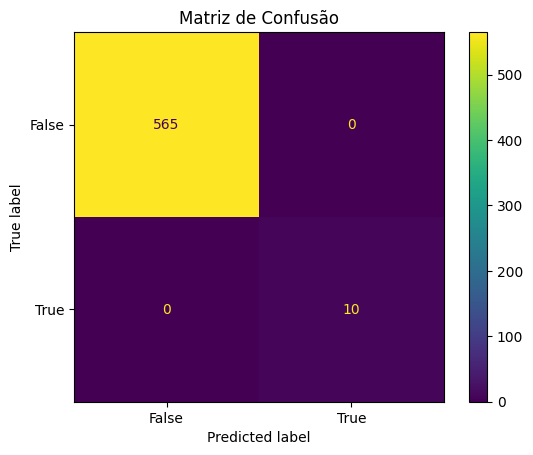

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de Confusão
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Matriz de Confusão")
plt.show()


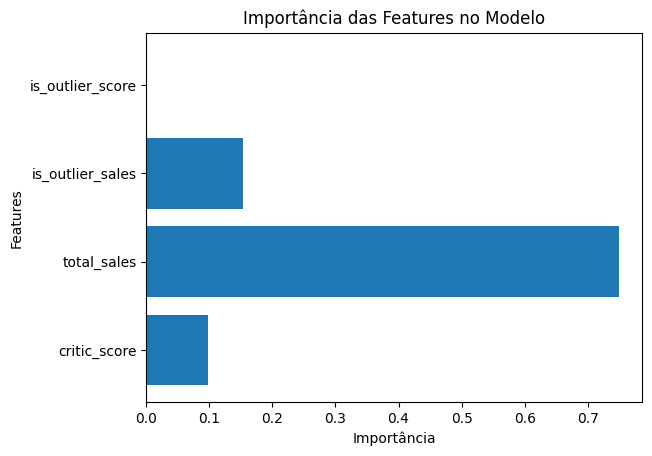

In [27]:
# Importância das features
importances = model.feature_importances_
features = X.columns
plt.barh(features, importances)
plt.xlabel("Importância")
plt.ylabel("Features")
plt.title("Importância das Features no Modelo")
plt.show()


Tive um resultado interessante, apesar de não ser o esperado o modelo me sugeriu um jogo que não estava dentro de nenhum dos requisitos minimos e não era um outlier: Star Wars: The Force Unleashed **7.1**  - **7.94**


In [28]:
# Fazer predições
y_pred = model.predict(X_test)

# Ver jogos sugeridos
suggested_games = consolidated_data[consolidated_data['final_label'] == True]
print(suggested_games[['title', 'critic_score', 'total_sales']])


                                       title  critic_score  total_sales
173                         Assassin's Creed           8.2        11.29
174                      Assassin's Creed II           9.1        11.41
177          Assassin's Creed IV: Black Flag           8.7        13.71
244                      Batman: Arkham City           9.6        10.29
258                            Battlefield 1           9.3        13.16
260                            Battlefield 3           8.9        17.32
261                            Battlefield 4           8.7        11.12
429           Call of Duty 4: Modern Warfare           9.6        18.33
431           Call of Duty: Advanced Warfare           9.1        21.78
432                  Call of Duty: Black Ops           8.8        30.99
433                Call of Duty: Black Ops 3           8.1        15.09
434               Call of Duty: Black Ops II           8.6        28.08
436                     Call of Duty: Ghosts           8.8      

Com esse cross validation é possivel ver que a acurácia ficou alta demais, caindo em overfitting. Mesmo com a tentativa de mudanças nos hiperparamêtros a acurácia caiu muito pouco.

In [29]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5)
print(f"Acurácia média (cross-validation): {scores.mean()}")


Acurácia média (cross-validation): 0.9982584456900471


Apenas usando esse critério podemos identificar que o modelo realmente trouxe vários jogos que foram ou selecionados ou concorreram a jogos do ano. Porém ele trouxe também todos os outros que se encaixavam no escopo pré-definido, mesmo tentando fazer com que ele me trouxesse jogos outliers que venderam muito e tiveram uma nota abaixo ou que não venderam tanto mas tiveram uma nota altissíma não foi atingido.

## Conclusões e Resumo

Neste projeto, o objetivo foi utilizar um modelo de machine learning para classificar jogos como candidatos ao prêmio **Game of the Year (GOTY)** com base em vendas totais e notas críticas.

### Desempenho do Modelo
- O modelo identificou jogos que atendem aos critérios mínimos de forma satisfatória.
- Apesar disso, não conseguiu sugerir jogos que, mesmo fora dos critérios, apresentassem características excepcionais.

### Características Relevantes
1. **Nota dos Críticos (`critic_score`)**: A variável mais influente.
2. **Vendas Totais (`total_sales`)**: Fator relevante para a classificação, especialmente para jogos populares.

### Melhorias Sugeridas
1. **Ajustar Hiperparâmetros**: Explorar técnicas como validação cruzada e *grid search* para melhorar a performance.
2. **Incorporar Novas Features**: Variáveis como gênero, plataforma e data de lançamento podem enriquecer o modelo.
3. **Reduzir Overfitting**: Usar regularização e técnicas de balanceamento para melhorar a generalização.
4. **Identificar Outliers**: Refinar a lógica para capturar jogos excepcionais fora dos critérios mínimos.

### Conclusão Final
O uso do **Random Forest** demonstrou ser eficaz, mas melhorias contínuas são necessárias para capturar padrões mais complexos nos dados. Com ajustes futuros, o modelo pode ser capaz de identificar jogos inovadores e excepcionais, alinhando-se às dinâmicas do mercado de jogos.
